# Grover search algorithm

In this section, we introduce Grover's search algorithm and how it can be used to solve unstructured search problems. We then implement Grover's algorithm on actual problems using Qiskit, run on a simulator and an actual quantum device.


## Contents

1. [Introduction](#introduction)      
2. [Setup](#setup)    
3. [Algorithm](#algorithm)     
   3.1 [Prepare the initial state](#algPrepare)    
   3.2 [Implement an oracle that can access the function $f(x)$ as a reflection](#algGrover)    
   3.3 [Apply the Grover diffusion operator](#algDiffusion)    
   3.4 [Repeat steps 2 and 3 approximately $\frac{\pi}{4}\sqrt{N}$ times and perform measurements](#algRepeat)    
   3.5 [Run the program with simulators and quantum devices](#algExecute)    
4. [References](#references)


## Introduction <a id='introduction'></a>

In mathematical terms, [Grover’s algorithm](https://arxiv.org/abs/quant-ph/9605043) was the first to demonstrate a quantum speedup on unstructured search problems. Denote $N=2^n$ as the data size and $n$ as the qubit number. An oracle function $f(x)$ is defined with $f(x_0)=1$ for an unknown $x_0$ and $f(x)=0$ for all other values of $x$ such that
$$\begin{cases} f(x)= f(x_0)= 1, \text{ for } x = x_0, \\ f(x)=0, \text{ for } x \neq x_0. \end{cases}$$



Grover search algorithm is a quantum algorithm for finding the input value $x_0$. The advantage of the algorithm is that when the Oracle function has $N$ possible input values, the algorithm only requires $\mathcal{O}(\sqrt{N})$ evaluations of the Oracle, while the best classical algorithm needs $\mathcal{O}(N)$ evaluations. In this tutorial, we are going to implement a search for an n-bit string item using a quantum circuit based on Grover’s Algorithm. Formulating Grover's search problem requires an oracle function that marks one or more computational basis states as the states we are interested in finding, and an amplitude amplification circuit that increases the amplitude of marked states, consequently suppressing the remaining states. 

## Setup  <a id='setup'></a>

First we use `pip` to install the packages that are required for this tutorial: `qiskit`, `pylatexenc`, `qiskit-aer`, and `qiskit-ibm-provider`.

In [1]:
!pip install qiskit
!pip install pylatexenc
!pip install qiskit-aer
!pip install qiskit-ibm-provider

Then we import the packages and tools that we need for this tutorial.

In [2]:
# Built-in modules
import math

# Imports from Qiskit
from qiskit import QuantumCircuit
from qiskit import QuantumRegister, ClassicalRegister

For example, let's assume the qubit number is $n=3$ and the problem size is $N=2^3=8$ as a small example. For simplicity, we assume the set is composed of eight binary strings $\{000, 001, 010, 011, 100, 101, 110, 111\}$. These eight strings have a natural correspondance to the three-qubit quantum computational basis set $\{|000\rangle, |001\rangle, |010\rangle， |011\rangle， |100\rangle， |101\rangle， |110\rangle， |111\rangle\}$. Let’s assume for now that only one string $x_0 \in \{000, 001, 010, 011, 100, 101, 110, 111\}$ satisfies $f(x)=f(x_0)=1$ while $f(x) = 0$ for any other $x \neq x_0 \in \{000, 001, 010, 011, 100, 101, 110, 111\}$  and our task is to find that string $x_0$. So we can create a quantum circuit with only three qubits and three classical bits as a small example.

In [3]:
n = 3
q = QuantumRegister(n,'q')
c = ClassicalRegister(n,'c')
groverCircuit = QuantumCircuit(q,c)

## Algorithm <a id='algorithm'></a>
The algorithm can be broken down into the following steps:
1. Prepare the initial state
2. Implement an oracle that can access the function $f(x)$ as a reflection
3. Apply the Grover diffusion operator
4. Repeat steps 2 and 3 approximately $\frac{\pi}{4}\sqrt{N}$ times and perform measurements
5. Run the program with simulators and quantum devices

### Step 1: prepare the initial state <a id='algPrepare'></a>
To perform the search, we are going to create an $n$-dimensional system, which has $N=2^n$ computational basis states, represented via $N$ binary numbers. More specifically, bit strings with length $n$, labelled as $x_0,x_1,\dots,x_{N-1}$. We initialize the system in the uniform superposition over all states, i.e., the amplitudes associated with each of the basis states are equal to
$$|s_n\rangle=\frac{1}{\sqrt{N}}\sum_{x=0}^{N-1}|x\rangle.$$
Basically, for the three qubit example, the superposition state is given by $|s_3\rangle=\frac{1}{\sqrt{8}}\sum_{x=0}^{8-1}|x\rangle = \frac{1}{\sqrt{8}}(|000\rangle + |001\rangle + |010\rangle + |011\rangle + |100\rangle + |101\rangle + |110\rangle + |111\rangle)$. This can be achieved by applying a Hadamard gate `H` to each wire in the circuit.

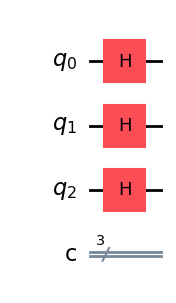

In [4]:
groverCircuit.h(q)
groverCircuit.draw(output='mpl', style="iqp")

### Step 2: implement an oracle that can access the function $f(x)$ as a reflection <a id='algGrover'></a>

Let’s assume for now that only one index satisfies $f(x)=1$. We are going to call this index $x_0$. To access $f(x)$ with an oracle, we can formulate a unitary operator $U_{f}$ such that $U_{f} | x \rangle = (-1)^{f(x)} | x \rangle$. To be specific,

$$\begin{cases} U_{f} | x \rangle = - |x\rangle, \text{ for } x=x_0 \text{ such that } f(x) = f(x_0) = 1, \\ U_{f} | x \rangle = |x\rangle, \text{ for } x \neq x_0 \text{ such that } f(x) = 0, \end{cases}$$

where $U_{f}$ acts by flipping the phase of the solution state while keeping the remaining states untouched. In other words, the unitary $U_{f}$ can be written as
$$U_{f} = I - 2 |x_0\rangle \langle x_0|.$$

Assume the solution string is $x_0=111$ for the above example. Let's dub the quantum state $|w\rangle = |x_0\rangle = |111\rangle$ that corresponds to the solution string as the **winner state**. And let's dub the quantum state $|b\rangle = \frac{1}{\sqrt{7}}(|000\rangle + |001\rangle + |010\rangle + |011\rangle + |100\rangle + |101\rangle + |110\rangle)$ that is composed of all other states as **bad state**. Then this oracle $U_{f}$ realizes the function given by

$$\begin{cases} U_{f} | x \rangle = - |x\rangle, \text{ for } |x\rangle = |w\rangle, \\ U_{f} | x \rangle = |x\rangle, \text{ for } |x\rangle = |b\rangle , \end{cases}$$

This can be recarded as a reflection operation over the reference state $|b\rangle$. By reflection, it means that the amplitude of the reference state $|b\rangle$ remains unchangled while the sign of the amplitude of orthogonal state is flipped. The reflection operation will also be used in the next step.
 
**figure1**

The three-qubit state $|s_3\rangle$ is given by the superposition of winner state and bad state such that $|s_3\rangle=\frac{1}{\sqrt{8}} |w\rangle + \frac{\sqrt{7}}{\sqrt{8}} |b\rangle$. Apply the oracle $U_f$ to the superposition state gives a new quantum state of $$U_{f}|s_3\rangle = - \frac{1}{\sqrt{8}} |w\rangle + \frac{\sqrt{7}}{\sqrt{8}} |b\rangle.$$



This operation can be achieved by applying a Controlled Controlled Z (`CCZ`) operation that flips the state $|111\rangle$ to $-|111\rangle$ while remaining the other states unchanged.
$$\begin{cases} [CCZ] | x \rangle = - |x\rangle, \text{ for } |x\rangle=|111\rangle, \\ [CCZ] | x \rangle = |x\rangle, \text{ for } |x\rangle \neq |111\rangle, \end{cases}$$



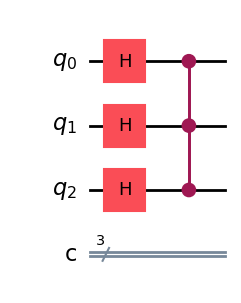

In [5]:
# Oracle operator
groverCircuit.ccz(q[0], q[1], q[2])
groverCircuit.draw(output='mpl', style="iqp")

### Step 3: apply the Grover diffusion operator <a id='algDiffusion'></a>

We now apply an additional reflection $U_{d}$ which is named as Grover diffusion operator. This operator is basically a reflection similar to the case as we discussed in the previous step, but simply changes the reference state $|b\rangle$ to the state $|s_3\rangle$. By reflection, it means that the amplitude of the reference state $|s_3\rangle$ remains unchangled while the sign of the amplitude of orthogonal state is flipped. Denote the quantum state that is orthogonal to $|s_3\rangle$ by $|s_3\rangle^{\perp}$. This operation realizes the function given by  
$$\begin{cases} U_{d} | x \rangle = - |x\rangle, \text{ for } |x\rangle = |s_3\rangle^{\perp}, \\ U_{d} | x \rangle = |x\rangle, \text{ for } |x\rangle = |s_3\rangle , \end{cases}$$
Similarly, this unitary $U_{d}$ can be written as
$$U_{d} = I - 2 |s_3\rangle^{\perp} \langle s_3|^{\perp}.$$
In the previous step, we decomposed $|s_3\rangle$ by the superposition of winner state and bad state $|s_3\rangle=\frac{1}{\sqrt{8}} |w\rangle + \frac{\sqrt{7}}{\sqrt{8}} |b\rangle$. So we can also decompose the orthogonal state $|s_3\rangle^{\perp}$ by the superposition of winner state and bad state $|s_3\rangle^{\perp}=-\frac{\sqrt{7}}{\sqrt{8}} |w\rangle + \frac{1}{\sqrt{8}} |b\rangle$. So the diffusion unitary operator can also be decomposed using winner state and bad state such that
$$U_{d}=I - 2 |s_3\rangle^{\perp} \langle s_3|^{\perp} = I - \frac{7}{4} |w\rangle \langle w| + \frac{\sqrt{7}}{4} |w\rangle \langle b| + \frac{\sqrt{7}}{4} |b\rangle \langle w| - \frac{1}{4} |b\rangle \langle b|.$$
Apply the Grover diffusion operator $U_d$ to the state $U_{f}|s_3\rangle$ gives us a new state of $$U_dU_{f}|s_3\rangle=\frac{5}{2}\frac{1}{\sqrt{8}}|w\rangle + \frac{1}{2}\frac{\sqrt{7}}{\sqrt{8}}|b\rangle.$$

**figure2**

Now let's think about the circuit implementation of this Grover diffusion operator $U_d$. Recall that in the previous step, we use the Controlled Controlled Z (`CCZ`) operation to flip the state $|111\rangle$ to $-|111\rangle$ while remaining the other states unchanged. In quantum computation, the global phase of a quantum state does not matter for the task, as in most cases we only care about the density matrix or expectation value. So in the quantum computation scenario, we regard two quantum states with the only difference in global phase as the same quantum state, i.e. $|\psi\rangle \equiv e^{i\phi}|\psi\rangle$, for any $\phi \in [0, 2 \pi)$. As a special case of $\phi=\pi$, the quantum state $|\psi\rangle \equiv e^{i\pi}|\psi\rangle = -|\psi\rangle.$ So back to our discussion, if we extract a global phase of $e^{i\pi}$ out of the quantum state, we can also regard the `CCZ` operation as to remian the state $|111\rangle$ unchanged but flip all the signs of amplitude of the other states. Basically,
$$\begin{cases} [CCZ] | x \rangle = - |x\rangle, \text{ for } |x\rangle=|111\rangle, \\ [CCZ] | x \rangle = |x\rangle, \text{ for } |x\rangle \neq |111\rangle, \end{cases} \quad \equiv \quad \begin{cases} [CCZ] | x \rangle = |x\rangle, \text{ for } |x\rangle=|111\rangle, \\ [CCZ] | x \rangle = - |x\rangle, \text{ for } |x\rangle \neq |111\rangle, \end{cases} $$
up to a global phase of $e^{i\pi}$. This inspires us to explore about some modifications based on this magic `CCZ` gate. If we add two layer of X gates and Hadamard gates before and after the operation of `CCZ` gate sequentially to all the qubits, we can have the operation $H^{\otimes 3} X^{\otimes 3} [CCZ] X^{\otimes 3}H^{\otimes 3}$ composed of `X` gates, `H` gates, and `CCZ` gates. Recall the basic quantum gates `X` and `H` are given by
$$X|0\rangle = |1\rangle, X|1\rangle = |0\rangle, X|+\rangle = |+\rangle, X|-\rangle = -|-\rangle;$$
$$H|0\rangle = |+\rangle, H|1\rangle = |-\rangle, H|+\rangle = |0\rangle, H|-\rangle = |1\rangle,$$
where $|+\rangle=\frac{1}{\sqrt{2}}(|0\rangle + |1\rangle)$ is the plus state and $|-\rangle=\frac{1}{\sqrt{2}}(|0\rangle - |1\rangle)$ is the minus state. We can verify that the operation $H^{\otimes 3} X^{\otimes 3} [CCZ] X^{\otimes 3}H^{\otimes 3}$ realizes the function given by
$$\begin{cases} H^{\otimes 3} X^{\otimes 3} [CCZ] X^{\otimes 3}H^{\otimes 3} | x \rangle = |x\rangle, \text{ for } |x\rangle = |+\rangle^{\otimes 3}, \\ H^{\otimes 3} X^{\otimes 3} [CCZ] X^{\otimes 3}H^{\otimes 3} | x \rangle = - |x\rangle, \text{ for } |x\rangle \neq |+\rangle^{\otimes 3}, \end{cases}$$

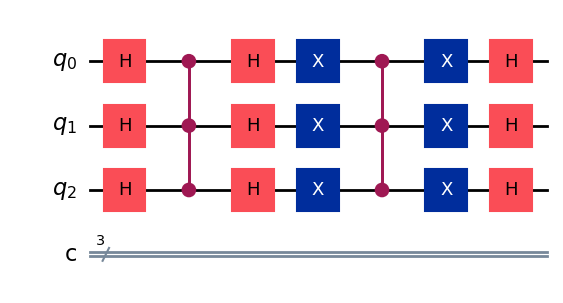

In [6]:
# Diffusion operator
groverCircuit.h(q)
groverCircuit.x(q)
groverCircuit.ccz(q[0], q[1], q[2])
groverCircuit.x(q)
groverCircuit.h(q)
groverCircuit.draw(output='mpl', style="iqp")

### Step 4: repeat steps 2 and 3 approximately $\frac{\pi}{4}\sqrt{N}$ times and perform measurements <a id='algRepeat'></a>

Compare the state $U_dU_f|s_3\rangle=\frac{5}{2}\frac{1}{\sqrt{8}}|w\rangle + \frac{1}{2}\frac{\sqrt{7}}{\sqrt{8}}|b\rangle$ to the original state $|s_3\rangle=\frac{1}{\sqrt{8}} |w\rangle + \frac{\sqrt{7}}{\sqrt{8}} |b\rangle$. We can notice that the amplitude of the winner state $|w\rangle$ increases after applying the Grover oracle $U_f$ and the diffucion operator $U_d$. Our goal for the problem is to make the state evolve to the solution eventually. We can derive how many times do we need in order to get the winner state. Notice that each time after the Grover oracle $U_f$ and the diffucion operator $U_d$, the quantum state is rotated towards the winner state by the angle of $2\theta$, where $\theta = \arcsin{\frac{1}{\sqrt{N}}}$. When the size of the dataset $N$ is large, the angle is approximately calculated by $\theta = \arcsin{\frac{1}{\sqrt{N}}}\approx \frac{1}{\sqrt{N}}$. Assume we iterate the Grover oracle and diffusion operator for $k$ times in order to rotate the initial state to the winner state by the angle of $\frac{\pi}{2}$. Then $k$ is obtained by $2\theta \times k = \frac{\pi}{2}$ such that $k = \frac{\pi}{4}\sqrt{N}.$ So after $k = \frac{\pi}{4}\sqrt{N}$ iterations of the algorithm, we can get the solution as the winner state $|w\rangle$.






For the above example of $N=8$, we can iterate the algorithm for $2$ times and then measure all the qubits. By computing the statistics of measurement output, we can have a probability distribution such that the probability of bit string `111` is the highest.

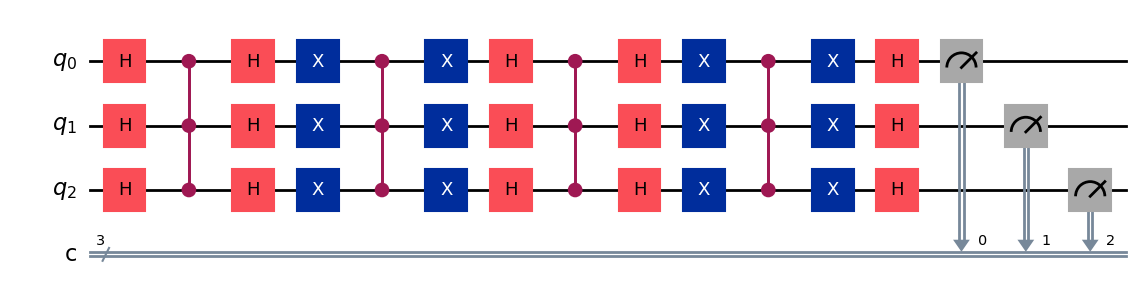

In [7]:
# Repeat the oracle and diffusion operator one more time and measure the output

# Oracle operator
groverCircuit.ccz(q[0], q[1], q[2])

# Diffusion operator
groverCircuit.h(q)
groverCircuit.x(q)
groverCircuit.ccz(q[0], q[1], q[2])
groverCircuit.x(q)
groverCircuit.h(q)

# Measurement
groverCircuit.measure(q, c)

groverCircuit.draw(output='mpl', style="iqp")

### Step 5: run the program with simulators and quantum devices <a id='algExecute'></a>
Now we have elaborated every details of Grover search algorithm and designed the circuit for implementation. It's time to execute our program with `Aer` simulator and quantum hardware on IBM Quantum platform.

In [8]:
# Run the program and get results by simulators
from qiskit import transpile
from qiskit_aer import AerSimulator

# Get the backend for simulation
simulatorBackend = AerSimulator()

# Before we run the circuit, we need to transpile the circuit to match the backend structure
transpiledGrovercircuit = transpile(groverCircuit, simulatorBackend)

# Run job
shots = 1024
job = simulatorBackend.run(transpiledGrovercircuit, shots=shots)

# Get the result and print the counts
result = job.result()
count = result.get_counts()
print(count)

{'111': 973, '011': 8, '110': 5, '000': 6, '010': 8, '100': 9, '101': 10, '001': 5}


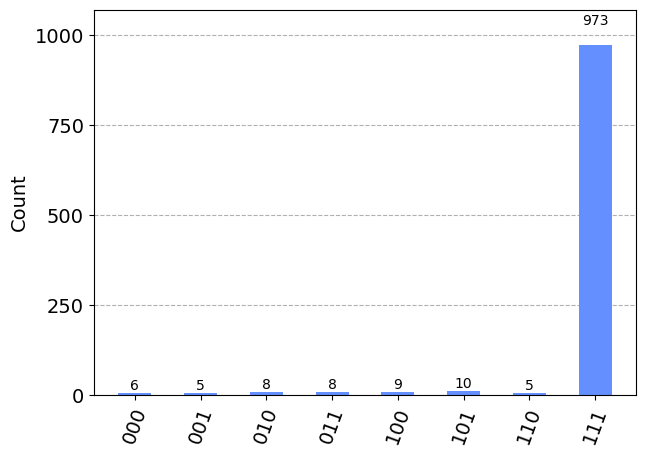

In [9]:
from qiskit.visualization import plot_histogram
plot_histogram(count)

We can see from the figure that the bit string `111` has the highest probability which corresponds to our solution. Alternatively, we can also run the program using real quantum devices from IBM Quantum platform.

In [ ]:
# # Run the program and get results by quantum hardware
# from qiskit import transpile
# from qiskit_ibm_provider import IBMProvider

# # Get the backend for quantum execution
# provider = IBMProvider()
# hub = "ibm-q"
# group = "open"
# project = "main"
# quantumBackend = provider.get_backend('ibmq_qasm_simulator', instance=f"{hub}/{group}/{project}")

# # Before we run the circuit, we need to transpile the circuit to match the backend structure
# transpiledGrovercircuit = transpile(groverCircuit, quantumBackend)

# # Run job
# shots = 1024
# job = quantumBackend.run(transpiledGrovercircuit, shots=shots)
# jobID = job.job_id()
# print(jobID)

In [ ]:
# # Check the status
# jobStatus = provider.retrieve_job(jobID).status()

In [ ]:
# retreiveJob = provider.retrieve_job(jobID)
# result = retreiveJob.result()
# count = result.get_counts()
# print(count)